# menganalisis sentimen pengguna twitter terhadap kata kunci "Piala Dunia"

### import data

In [1]:
import pandas as pd 
import re
import string
import nltk
import numpy as np
import json
import tweepy
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

### menambahkan query "piala dunia" sebanyak 500

In [3]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
query = "piala dunia"
tweets = tweepy.Cursor(api.search_tweets, q=query, lang='id').items(500)
data = []
for tweet in tweets:
    data.append([tweet.text])
df = pd.DataFrame(data, columns=['Tweet'])
df

,Tweet
0,RT @kiminigyu: Gagal Jadi Tuan Rumah Piala Dun...
1,RT @republikaonline: Rakyat negara Arab memuji...
2,@hijabersshangat Kenapa sih Pak? Kecewa banget...
3,RT @kiminigyu: Gagal Jadi Tuan Rumah Piala Dun...
4,RT @KepaArgawinata2: BREAKING NEWS !!! \n\nIni...
...,...
495,Gara gara oknum yang ga konsisten membuat usah...
496,perjuangan erick thohir diapresiasi keringat d...
497,"Di setiap perjuangan pasti ada kegagalan ,,mak..."
498,Sekang malah muncul kekecewaan dan rasa khawat...


### Data Prepocessing

In [4]:
def preprocess_text(text):

    text = re.sub(r'^RT[\s]+', '', text)

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'@\w+|#\w+', '', text)

    text = text.translate(str.maketrans('', '', string.punctuation))

    text = text.lower()

    words = text.split()

    text = ' '.join(words)

    text = re.sub('\s+', ' ', text).strip()
    return text

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
def remove_stopwords(text):
    stop_words = set(nltk.corpus.stopwords.words('indonesian'))
    stop_words.add('piala')
    stop_words.add('dunia')
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if not word in stop_words]
    text = ' '.join(filtered_tokens)
    return text
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xxx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xxx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    text = ' '.join(stemmed_tokens)
    return text

In [7]:
df['tweet_clean'] = df['Tweet'].apply(preprocess_text)
df['tweet_clean'] = df['tweet_clean'].apply(remove_stopwords)
df['tweet_clean'] = df['tweet_clean'].apply(stemming)
df

,Tweet,tweet_clean
0,RT @kiminigyu: Gagal Jadi Tuan Rumah Piala Dun...,gagal tuan rumah u20 pupu mimpi anak bangsa in...
1,RT @republikaonline: Rakyat negara Arab memuji...,rakyat negara arab memuji sikap bangsa indones...
2,@hijabersshangat Kenapa sih Pak? Kecewa banget...,sih kecewa banget loh bacanya indonesia tuan r…
3,RT @kiminigyu: Gagal Jadi Tuan Rumah Piala Dun...,gagal tuan rumah u20 pupu mimpi anak bangsa in...
4,RT @KepaArgawinata2: BREAKING NEWS !!! \n\nIni...,break news pemain yg membatalkan indonesia tua...
...,...,...
495,Gara gara oknum yang ga konsisten membuat usah...,gara gara oknum ga konsisten usaha erick sia s...
496,perjuangan erick thohir diapresiasi keringat d...,perjuangan erick thohir diapresiasi keringat a...
497,"Di setiap perjuangan pasti ada kegagalan ,,mak...",perjuangan kegagalan bangkit indonesia pupu mi...
498,Sekang malah muncul kekecewaan dan rasa khawat...,sekang muncul kekecewaan khawatir pemain timna...


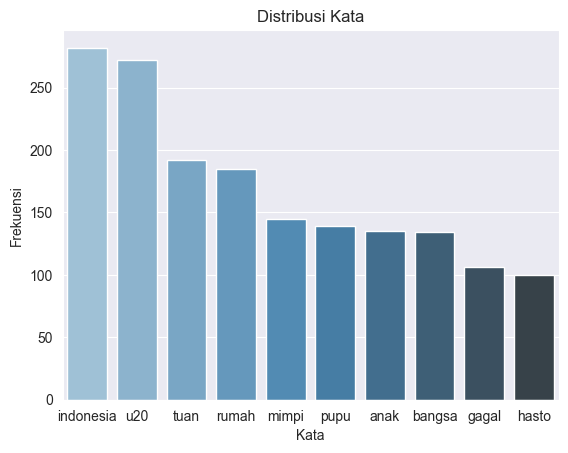

In [8]:
import seaborn as sns
sns.set_style("darkgrid")
words = []
for tweet in df["tweet_clean"]:
    words.extend(re.findall(r'\b\w+\b', tweet))
word_freq = pd.Series(words).value_counts()
top10 = word_freq[:10].reset_index(name='counts').rename(columns={'index':'words'})
sns.barplot(x='words', y='counts', data=top10, palette='Blues_d')
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.title("Distribusi Kata")
plt.show()


hasil dari keyword "piala dunia" adalah membahas tentang batalnya indonesia sebagai tuan rumah piala dunia

## Sentiment Analisis

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [10]:
df_tweets_model=pd.read_csv('dataset_komentar_instagram_cyberbullying.csv')
df_tweets_model

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,positive,Bangga sama suami yg selalu ingat istri disela...
396,397,positive,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,positive,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [11]:
df_tweets_model.rename(columns={"Instagram Comment Text":"Text"}, inplace=True)
df_tweets_model.drop(columns=["Id"],inplace=True,)
df_tweets_model.replace({"Sentiment":{"negative":0, "positive":1}}, inplace=True)


In [12]:
df_tweets_model['clean_text'] = df_tweets_model['Text'].apply(preprocess_text)
df_tweets_model['clean_text'] = df_tweets_model['clean_text'].apply(remove_stopwords)
df_tweets_model['clean_text'] = df_tweets_model['clean_text'].apply(stemming)
df_tweets_model

,Sentiment,Text,clean_text
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,usernam tolol gak hubungan nya keguguran dgn p...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tatacowo bgt dibela2in balikanhadeww...
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek2 skr lengket lg duhhh labil bgt ...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kesel att nya gausah anaknya kasian pe...
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lgsakit jiwaknp yg jd peran...
...,...,...,...
395,1,Bangga sama suami yg selalu ingat istri disela...,bangga suami yg istri disela apapun profesimu ...
396,1,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun pekerjaannya yg halal u tuk menafkahi k...
397,1,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayorita pegangguran gak kerja tru putu ...
398,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...,usernam aslinya cantik ayu loh mbak krn bertem...


In [13]:
vectorizer = TfidfVectorizer (max_features=2500)

model_g = GaussianNB()
v_data = vectorizer.fit_transform(df_tweets_model['clean_text']).toarray()
X_train, X_test, y_train, y_test = train_test_split(v_data, df_tweets_model['Sentiment'], test_size=0.2, random_state=18)

model_g.fit(X_train,y_train)

GaussianNB()

In [14]:
y_preds = model_g.predict(X_test)
v_data = vectorizer.transform(df['tweet_clean']).toarray()

y_classification = model_g.predict(v_data)

In [15]:
df["sentiment"] = list(y_classification)

In [16]:
df

,Tweet,tweet_clean,sentiment
0,RT @kiminigyu: Gagal Jadi Tuan Rumah Piala Dun...,gagal tuan rumah u20 pupu mimpi anak bangsa in...,1
1,RT @republikaonline: Rakyat negara Arab memuji...,rakyat negara arab memuji sikap bangsa indones...,1
2,@hijabersshangat Kenapa sih Pak? Kecewa banget...,sih kecewa banget loh bacanya indonesia tuan r…,0
3,RT @kiminigyu: Gagal Jadi Tuan Rumah Piala Dun...,gagal tuan rumah u20 pupu mimpi anak bangsa in...,1
4,RT @KepaArgawinata2: BREAKING NEWS !!! \n\nIni...,break news pemain yg membatalkan indonesia tua...,1
...,...,...,...
495,Gara gara oknum yang ga konsisten membuat usah...,gara gara oknum ga konsisten usaha erick sia s...,1
496,perjuangan erick thohir diapresiasi keringat d...,perjuangan erick thohir diapresiasi keringat a...,1
497,"Di setiap perjuangan pasti ada kegagalan ,,mak...",perjuangan kegagalan bangkit indonesia pupu mi...,1
498,Sekang malah muncul kekecewaan dan rasa khawat...,sekang muncul kekecewaan khawatir pemain timna...,1


In [17]:
jumlah_komentar_positif = (df['sentiment'] == 1).sum()
jumlah_komentar_negatif = (df['sentiment'] == 0).sum()
print('jumlah komentar positif sebanyak '+ str(jumlah_komentar_positif) + ' dari 500 tweet')
print('jumlah komentar negatif sebanyak '+ str(jumlah_komentar_negatif) + ' dari 500 tweet')

jumlah komentar positif sebanyak 398 dari 500 tweet
jumlah komentar negatif sebanyak 102 dari 500 tweet


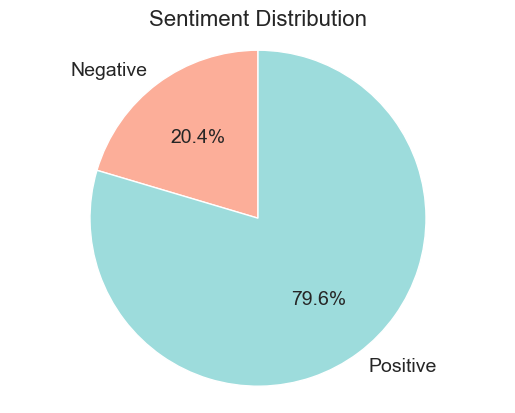

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Negative', 'Positive']
sizes = [len(df[df['sentiment'] == 0]), len(df[df['sentiment'] == 1])]
colors = ['#FCAE99','#9DDCDC']

sns.set_palette(sns.color_palette(colors))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.axis('equal')
plt.title('Sentiment Distribution', fontsize=16)
plt.show()



##### kesimpulan :

    - hasil analisis masyarakat indonesia tentang piala dunia membahas tentang batalnya indonesia sebagai tuan rumah piala dunia u-20

    - tidak ada atau sedikit sekali yang membahas piala dunia senior. hal ini dibuktikan dari 10 kata terbanyak tidak ada kata yang berkaitan tentang "argentina", "messi" ataupun "prancis"

    - sentimen masyarakat indonesia tentang piala dunia memiliki komentar positif yang lebih tinggi dibanding komentar negatif

    - meskipun memiliki komentar positif yang lebih banyak, persentase komentar negatif memiliki nilai yang cukup tinggi, yaitu sebanyak 20,4%